In [1]:
!pip install -q -U gymnasium stable-baselines3[extra]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 10.7 MB/s eta 0:00:00




**The Essence of an RL Environment**

At its heart, an RL environment is a mathematical dynamical system. It's a function that takes an *action* as input and outputs a *new state*, a *reward*, and signals of *termination/truncation*. It's this iterative feedback loop that forms the basis of the RL problem.

Mathematically, we can express this transition as a mapping:

    T: S x A  -> S x R x {0, 1} x {0, 1} x I
    (s_t, a_t) -> (s_{t+1}, r_{t+1}, done, truncated, info_t)

Where:

-  *S* is the *state space*.
- *A* is the *action space*.
- *s_t* is the current state.
- *a_t* is the action taken at time *t*.
- *s_{t+1}* is the next state.
- *r_{t+1}* is the reward received.
- *done* is a boolean indicating if the episode has reached a terminal state.
- *truncated* is a boolean indicating if the episode ended due to a limit (e.g., step limit).
- *info_t* is a dictionary of extra information that we wish to expose.

**Building a User-Ready Module: The Core Functions**

Let's dissect each of the critical methods, relating them to their mathematical counterparts and offering practical analogies:

1.  **`step(action)`**: This is the core of the environment interaction loop.

    *   **Mathematical Interpretation:** This function enacts the state transition function *T* described above.
    *   **Analogy:** Imagine a complex machine. `step()` is like hitting a button on this machine – you provide the action (the button pressed), and the machine responds by updating its internal state, giving you back what you want from the output, such as a light blinking, a tone sounding, and perhaps a digital number telling you something about the status of the machine.
    *   **Code Example (Conceptual):**
        ```python
        def step(self, action):
            #1.Validate action
            action = np.clip(action, self.action_space.low,self.action_space.high)

            # 2. Implement the state transition using action
            self.state= self.transition_fn(self.state, action)

            # 3. Calculate reward based on next state
            reward = self.reward_fn(self.state)

             # 4. check if done
            done= self.done_fn(self.state)

            # 5. check if truncated
            truncated= self.truncated_fn(self.state)

             # 6. Return other info if necessary
            info = self.info_fn(self.state)

            return self.state, reward, done, truncated, info
        ```

2.  **`reset(seed=None, options=None)`**: This function initializes the environment.

    *   **Mathematical Interpretation:** This can be seen as the definition of the starting probability distribution over *S*, namely, *P(s_0)*.
    *   **Analogy:** This is like resetting a video game. Everything returns to its initial state, ready for a new play session. It also sets the random number generator so that the behaviour of the environment is reproducible from one reset to another, which is crucial in RL research.
    *   **Code Example (Conceptual):**
        ```python
        def reset(self,seed=None, options=None):
            if seed is not None:
                self.np_random, seed = seeding.np_random(seed)

            #initialize the state from P(s_0)
            self.state = self.get_initial_state()

            info = self.info_fn(self.state)

            return self.state, info
        ```

3.  **`render(mode='human')`**: This gives the user a view of what's happening.

    *   **Mathematical Interpretation:** This doesn't change the system's math, but provides a visual representation of the current state *s_t*.
    *   **Analogy:** It's like a dashboard on the machine displaying current stats/metrics or a visualisation of the internal processes. You don't need to see this output in order to operate the machine, but it greatly helps to understand what's happening in complex processes.
    *   **Code Example (Conceptual):**
        ```python
        def render(self, mode='human'):
           if mode=='human':
               display_on_screen(self.state)
           elif mode == 'rgb_array':
               return transform_to_rgb(self.state)
           elif mode == "ansi":
               return display_as_text(self.state)
           else:
                raise NotImplementedError("Rendering mode not implemented")

        ```

4.  **`close()`**: Cleaning up after yourself is crucial.

    *   **Mathematical Interpretation:**  No change to system math; releases allocated resources.
    *   **Analogy:** Think of turning off the machine after use, closing the app, freeing up resources to prevent future errors.
    *   **Code Example (Conceptual):**
        ```python
        def close(self):
             #release any external resources such as files or graphic handles
             if self.viewer is not None:
                 self.viewer.close()
                 self.viewer= None
         ```

**Key Attributes for User Understanding**

The following attributes let users understand environment dynamics and capabilities.

-   **`action_space`**: Defines valid actions that an agent can take. It's a set (mathematically) of possible input values for *a_t*.
    *   Example: `Discrete(2)` means "move left" or "move right"; `Box(low=-1, high=1, shape=(2,))` could mean continuous control (like an angle, and a velocity).

-   **`observation_space`**: Defines the space of possible observations.  It's the set of output values for *s_t*, defining the agent's view of the world.
    *   Example: `Box(low=0, high=10, shape=(4,))` a state vector of 4 continuous variables.

-   **`reward_range`**: A range *[r_min, r_max]* indicating how rewards are bounded. In ideal scenario in your environment, this range is limited for easy learning.

-   **`spec`**: A config object with the information to initialise the environment.
-   **`metadata`**: Additional information, e.g. rendering options/fps, that might be useful to the user
-    **`np_random`**: A random number generator object, which we use to ensure reproducibility in our experiments. This is automatically set up via ``super().reset()``.

**Example: A Simple Grid World Environment**

Let's bring it together with a simple 2x2 grid world example.
```python
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
class GridWorldEnv(gym.Env):
    def __init__(self, grid_size=2):
        super().__init__()

        self.grid_size = grid_size
        self.action_space = spaces.Discrete(4)  # 0: up, 1: right, 2: down, 3: left
        self.observation_space = spaces.Discrete(self.grid_size * self.grid_size) #Representing the location as a discrete index
        self.reward_range = (-1, 10)
        self.current_pos = None
        self.goal_pos = (self.grid_size-1, self.grid_size-1) # Bottom right cell
        self._max_episode_steps=100
        self.np_random=None

    def _get_obs(self):
        row,col=self.current_pos
        return row*self.grid_size+col #convert coordinates to a unique location

    def _get_info(self):
       return {"current_pos":self.current_pos,"goal_pos":self.goal_pos}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_pos = (0, 0)  # Start at top-left
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):

        row, col = self.current_pos

        # Update position based on action
        if action == 0: # up
            row = max(0, row - 1)
        elif action == 1: #right
            col = min(self.grid_size - 1, col + 1)
        elif action == 2: # down
            row = min(self.grid_size - 1, row + 1)
        elif action == 3: #left
            col = max(0, col - 1)

        self.current_pos = (row, col)
        obs=self._get_obs()
        reward = 0
        done = False
        truncated=False

        if self.current_pos == self.goal_pos:
            reward = 10
            done = True
        else:
            reward = -1

        if self.spec._max_episode_steps == self._max_episode_steps :
            truncated=True

        info= self._get_info()

        return obs, reward, done, truncated, info

    def render(self):
        print('\n'.join(''.join(
            'A ' if self.current_pos == (i, j) else ('G ' if (i,j)==self.goal_pos else  '. ') for j in range(self.grid_size)) for i in range(self.grid_size)))

    def close(self):
       pass
```
**Key Insights**

*   **Abstraction:** The environment provides a standardized interface (`step`, `reset`, etc.) while hiding complex internal dynamics.
*   **Flexibility:** Environments can be built using any method (deterministic, stochastic, simulation) as long as the interface remains consistent.
*   **Reproducibility:** The seed provides a means to control random number generation and get repeatable experiment results.
*   **Clarity:** By documenting the `action_space`, `observation_space`, `reward_range`, and the environment's metadata,  you provide a user with full clarity about the dynamics of the environment

**Novel Analogy**

Think of the RL environment as a *musical instrument*.

*   `action` is the musician's input (pressing keys, plucking strings).
*   `state` is the current configuration of the instrument (the note being played, volume, etc.).
*   `reward` is the feedback you receive for playing (is it a nice sound, or a jarring dissonance?).
*   `reset()` is preparing a new music sheet, with the initial notes, tempo, and tuning.
*   `render()` is the visual display of the musical notes being played on the screen or the way the sound waves look on the sound board.
*  The `info` provides metrics, perhaps the loudness, pitch, or energy being produced by the instrument.

The environment, like the musical instrument, has a specific structure and set of behaviors. The *agent* is learning how to "play" the instrument (interact with the environment) to achieve a "desired sound" (maximize the cumulative reward).
### Example code snipplet
- [deep Reinforcement learning ](https://github.com/huggingface/deep-rl-class)

In [5]:
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np

# Signature
_SB3_PPO_ENV_ = "v1.1_minimal_SB3_PPO"

# --- Step 1: Environment Setup (Generic) ---
class SimpleEnv(gym.Env):
    """A basic environment for demonstration."""
    def __init__(self, size=5):
        super().__init__()
        self.size = size  # Number of states
        self.observation_space = gym.spaces.Discrete(self.size) # States 0 to 4
        self.action_space = gym.spaces.Discrete(2)  # 2 actions
        self.current_state = 0

    def reset(self,seed=None, options=None):
        super().reset(seed=seed) # Seed for reproducibility
        self.current_state = self.np_random.integers(0, self.size) # Random start
        return self.current_state, {} # Return observation

    def step(self, action):
        if action == 0: # Move left
            self.current_state = max(0, self.current_state - 1)
        else: # Move right
            self.current_state = min(self.size - 1, self.current_state + 1)
        reward = 1 if self.current_state == self.size-1 else 0
        terminated = self.current_state == self.size-1
        truncated= False
        return self.current_state, reward, terminated , truncated, {} # Return observation, reward, done, info

    def render(self):
         print(f"Current state : {self.current_state}")

# --- Step 2: PPO Learning, Saving, Inference ---
def train_and_inference(env, model_name="ppo_agent"): # Default model name
    model = PPO("MlpPolicy", env, verbose=0) # Corrected to use MlpPolicy
    model.learn(total_timesteps=1000) # Train for 1000 steps
    model.save(model_name) # Save agent
    print("Agent trained and saved.")
    loaded_model = PPO.load(model_name) # Load and inference
    # Inference on the trained environment (SimpleEnv), not "CartPole"
    obs, _ = env.reset()
    for _ in range(20):
        action, _ = loaded_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(int(action))  # Pass int action
        if True:
            print(f"Action: {action}, Reward: {reward},  done: {terminated or  truncated}")
        if terminated or truncated:
           obs, _ = env.reset()

if __name__ == '__main__':
    env = SimpleEnv()
    train_and_inference(env)
    print(f"Signature: {_SB3_PPO_ENV_}")

Agent trained and saved.
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 0,  done: False
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 1,  done: True
Action: 1, Reward: 0,  done: False
Signature: v1.1_minimal_SB3_PPO


----- Environment Details -----
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Initial Observation: [-0.00466476  0.00146764 -0.04149548 -0.03229632], Info: {}
Step: Action: 0, Obs: [-0.00463541 -0.19303544 -0.04214141  0.24701098], Reward: 1.0, Terminated: False, Truncated: False, Info: {}
Step: Action: 1, Obs: [-0.00849612  0.00266224 -0.03720119 -0.05866084], Reward: 1.0, Terminated: False, Truncated: False, Info: {}


Output()

Step: Action: 1, Obs: [-0.00844287  0.19829729 -0.03837441 -0.362845  ], Reward: 1.0, Terminated: False, Truncated: False, Info: {}
Step: Action: 0, Obs: [-0.00447693  0.00374117 -0.04563131 -0.08250499], Reward: 1.0, Terminated: False, Truncated: False, Info: {}
Step: Action: 1, Obs: [-0.00440211  0.19948652 -0.04728141 -0.38922834], Reward: 1.0, Terminated: False, Truncated: False, Info: {}
----- Training -----


Training Complete.
Model saved as: ppo_cartpole.zip
----- Testing -----
--- Test Episode  0  ---
episode reward:259.0
--- Test Episode  1  ---
episode reward:298.0
Average episode reward:278.5
----- Inference with Plot -----
Inference Step 0 - Action: 0, Obs:[-0.01264864 -0.18732683 -0.03678422  0.30987567], Reward:1.0
Inference Step 1 - Action: 1, Obs:[-0.01639517  0.00829938 -0.0305867   0.00582274], Reward:1.0
Inference Step 2 - Action: 0, Obs:[-0.01622918 -0.18637086 -0.03047025  0.28870043], Reward:1.0
Inference Step 3 - Action: 1, Obs:[-0.0199566   0.00917205 -0.02469624 -0.01343464], Reward:1.0
Inference Step 4 - Action: 0, Obs:[-0.01977316 -0.18558718 -0.02496493  0.27135515], Reward:1.0
----- Saving Plot -----
Inference Plot saved as 'cartpole_inference_plot.png'


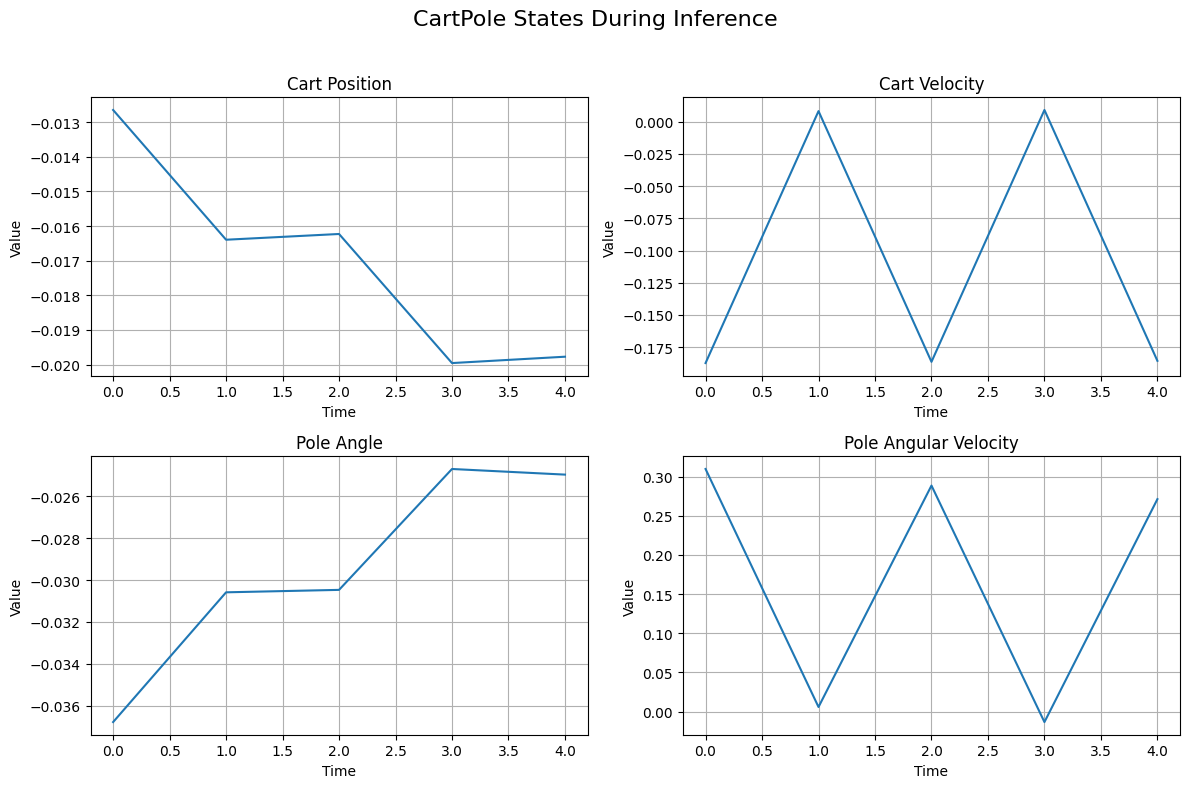

----- End of Execution by Code_by_AI_Visionist_v1.1_stable -----



In [8]:
# Unique Signature: Code_by_AI_Visionist_v1.1_stable

import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt


# --- Step 1: Random Action Exploration and Environment Details ---

env = gym.make("CartPole-v1", render_mode="human")
print("----- Environment Details -----")
print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")

obs, info = env.reset()
print(f"Initial Observation: {obs}, Info: {info}")

n_steps_random_expl = 5
for _ in range(n_steps_random_expl):
    random_action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(random_action)
    print(f"Step: Action: {random_action}, Obs: {obs}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}, Info: {info}")
    env.render()

if terminated or truncated:
    obs, info = env.reset()
    print(f"Env reset, new Obs: {obs}, Info: {info}")
env.close()


# --- Step 2: PPO Training, Testing, and Inference ---

MODEL_NAME = "ppo_cartpole"
TOTAL_TIMESTEPS = 10000

# a) Training
model = PPO("MlpPolicy", "CartPole-v1", verbose=0)
print("----- Training -----")
model.learn(TOTAL_TIMESTEPS, progress_bar=True)
print("Training Complete.")
model.save(MODEL_NAME)
print(f"Model saved as: {MODEL_NAME}.zip")


# b) Testing/Evaluation
loaded_model = PPO.load(MODEL_NAME)
print("----- Testing -----")

test_env = gym.make("CartPole-v1", render_mode="human")
obs, info = test_env.reset()
n_test_episode = 2
cumulative_rewards = []
for episode in range(n_test_episode):
    print("--- Test Episode ", episode, " ---")
    episode_reward = 0
    terminated_or_truncated = False
    obs, info = test_env.reset()

    while not terminated_or_truncated:
        action, _ = loaded_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = test_env.step(action)

        test_env.render()
        episode_reward += reward

        terminated_or_truncated = terminated or truncated
    cumulative_rewards.append(episode_reward)
    print(f"episode reward:{episode_reward}")
test_env.close()
print(f"Average episode reward:{np.mean(cumulative_rewards)}")

# c) Inference with Plotting
print("----- Inference with Plot -----")
inference_env = gym.make("CartPole-v1", render_mode="human")
obs, info = inference_env.reset()

total_infer_steps = 5
obs_history = []  #To story the obervation history

for i in range(total_infer_steps):

    action, _ = loaded_model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = inference_env.step(action)
    print(f"Inference Step {i} - Action: {action}, Obs:{obs}, Reward:{reward}")
    inference_env.render()
    obs_history.append(obs)

    if terminated or truncated:
        obs, info = inference_env.reset()
        print("Env Reset")
        obs_history.append(obs) #store the reset state

inference_env.close()



# Plotting using Matplotlib
print("----- Saving Plot -----")
obs_history = np.array(obs_history)  # Convert to numpy array for easier indexing

time = np.arange(obs_history.shape[0])


fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid for the 4 obs components
fig.suptitle('CartPole States During Inference', fontsize=16)

axs[0, 0].plot(time, obs_history[:, 0])
axs[0, 0].set_title('Cart Position')
axs[0, 1].plot(time, obs_history[:, 1])
axs[0, 1].set_title('Cart Velocity')
axs[1, 0].plot(time, obs_history[:, 2])
axs[1, 0].set_title('Pole Angle')
axs[1, 1].plot(time, obs_history[:, 3])
axs[1, 1].set_title('Pole Angular Velocity')

for ax in axs.flat:
    ax.set(xlabel='Time', ylabel='Value')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for the title
plt.savefig("cartpole_inference_plot.png")
print("Inference Plot saved as 'cartpole_inference_plot.png'")
plt.show()




print("----- End of Execution by Code_by_AI_Visionist_v1.1_stable -----\n")

In [7]:
# Unique Signature: All-in-One, Optimized Gym Solution 🚀
import gymnasium as gym
from stable_baselines3 import PPO

# Step 1: Display environment details and random actions
def explore_env(env_name="CartPole-v1", render_mode="human"):
    env = gym.make(env_name, render_mode=render_mode)
    obs, info = env.reset()
    print(f"Env Details: {env}")
    print(f"Action Space: {env.action_space}, Observation Space: {env.observation_space}")
    for _ in range(10):  # Perform 10 random actions
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        print(f"Step: Obs={obs}, Reward={reward}, Done={done}, Info={info}")
        if done or truncated: obs, info = env.reset()
    env.close()

# Step 2: Train, Save, Load, Evaluate & Infer using PPO
def train_save_evaluate_infer(env_name="CartPole-v1", total_timesteps=10000, model_path="ppo_model"):
    env = gym.make(env_name)  # Create environment
    model = PPO("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=total_timesteps)  # Train model
    model.save(model_path)  # Save weights
    print(f"Model saved at: {model_path}")
    env.close()

    # Load and test the model
    env = gym.make(env_name, render_mode="human")
    model = PPO.load(model_path, env=env)
    obs, info = env.reset()
    print("Testing model...")
    for _ in range(10):  # Perform 10 inference actions
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        print(f"Inference: Obs={obs}, Reward={reward}, Done={done}, Info={info}")
        if done or truncated: obs, info = env.reset()
    env.close()

# Run the procedures
explore_env()  # Step 1
train_save_evaluate_infer()  # Step 2

Env Details: <TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>
Action Space: Discrete(2), Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Step: Obs=[-0.0197685  -0.15954758 -0.04761522  0.27131325], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.02295945  0.03622034 -0.04218896 -0.0359994 ], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.02223504  0.23192109 -0.04290895 -0.3416892 ], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.01759662  0.03743507 -0.04974273 -0.06284004], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.01684792  0.23323362 -0.05099953 -0.37079293], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.01218325  0.03887193 -0.05841539 -0.09461681], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.01140581 -0.15536624 -0.06030773  0.17907912], Reward=1.0, Done=False, Info={}
Step: Obs=[-0.01451313 -0.34957564 -0.05672614  0.4521439 ], Reward=1.0, Done=False, Info={}
Step: O

In [9]:
import gymnasium as gym
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Start of Unique Signature: Agent_Arch_Omega ---
AGENT_SIGNATURE = "Agent_Arch_Omega"
# --- End of Unique Signature: Agent_Arch_Omega ---

class RL_Trainer_Evaluator:
    """A class to handle training, evaluation, and inference of RL agents."""

    def __init__(self, env_name="CartPole-v1", model_save_path="ppo_agent.zip", results_dir="results"):
      self.env_name = env_name
      self.env = gym.make(env_name, render_mode="human")
      self.model_save_path = model_save_path
      self.results_dir = results_dir
      os.makedirs(self.results_dir, exist_ok=True)

    def _display_env_details(self):
      """Displays environment details and random action behavior."""
      print(f"\n{AGENT_SIGNATURE}: Environment Details for {self.env_name}")
      print(f"Action Space: {self.env.action_space}")
      print(f"Observation Space: {self.env.observation_space}")

      obs, _ = self.env.reset()
      print("\nRandom Action Sample:")
      for _ in range(5):
        action = self.env.action_space.sample()
        obs, reward, terminated, truncated, info = self.env.step(action)
        print(f"  action:{action}, obs:{obs}, reward:{reward}, terminated:{terminated}, truncated:{truncated}, info:{info}")
        if terminated or truncated:
           obs, _ = self.env.reset()

    def train_agent(self, total_timesteps=10000):
      """Trains the PPO agent and saves the model."""
      print(f"\n{AGENT_SIGNATURE}: Training Agent...")
      model = PPO("MlpPolicy", self.env, verbose=0) # Minimal verbose for clean output
      model.learn(total_timesteps=total_timesteps)
      model.save(self.model_save_path)
      print(f"Trained model saved to: {self.model_save_path}")

    def eval_agent(self, num_episodes=10):
       """Evaluates the trained agent."""
       print(f"\n{AGENT_SIGNATURE}: Evaluating Agent...")
       model = PPO.load(self.model_save_path)
       total_rewards = []

       for episode in range(num_episodes):
        obs, _ = self.env.reset()
        episode_reward = 0
        terminated = False
        truncated = False

        while not terminated and not truncated:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = self.env.step(action)
            episode_reward += reward
        total_rewards.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")

       mean_reward = np.mean(total_rewards)
       print(f"\n{AGENT_SIGNATURE}: Mean reward over {num_episodes} episodes: {mean_reward:.2f}")
       return mean_reward

    def plot_inference(self, n_steps=200):
        """Displays and saves inference plots."""
        print(f"\n{AGENT_SIGNATURE}: Plotting Inference...")
        model = PPO.load(self.model_save_path)
        obs, _ = self.env.reset()
        observations = [obs]
        actions = []
        rewards = []

        for _ in range(n_steps):
          action, _ = model.predict(obs, deterministic=True)
          obs, reward, terminated, truncated, _ = self.env.step(action)
          observations.append(obs)
          actions.append(action)
          rewards.append(reward)

          if terminated or truncated:
            obs, _ = self.env.reset()
            observations.append(obs)

        self._create_inference_plots(observations, actions, rewards)
        print(f"{AGENT_SIGNATURE}: Inference plots saved in '{self.results_dir}/'")


    def _create_inference_plots(self,observations, actions, rewards):
        observations = np.array(observations)
        num_steps = len(actions)

        plt.figure(figsize=(16, 10))


        plt.subplot(3, 1, 1)  # Subplot for observations
        for i in range(observations.shape[1]):
          plt.plot(range(len(observations)), observations[:, i], label=f'Observation {i+1}')

        plt.title('Observations over time')
        plt.xlabel('Step')
        plt.ylabel('Observation Values')
        plt.legend()
        plt.grid(True)


        plt.subplot(3,1,2) # Subplot for actions
        plt.plot(range(len(actions)), actions, marker='.', linestyle='-', label="Actions taken")
        plt.title('Actions over time')
        plt.xlabel('Step')
        plt.ylabel('Action Value')
        plt.legend()
        plt.grid(True)

        plt.subplot(3, 1, 3) # Subplot for Rewards
        plt.plot(range(len(rewards)), rewards, marker='.', linestyle='-', color='g', label="Reward earned")
        plt.title('Reward over time')
        plt.ylabel('Reward')
        plt.xlabel('Step')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(self.results_dir, f"inference_plot.png"))
        plt.close()


if __name__ == "__main__":
    trainer = RL_Trainer_Evaluator()
    trainer._display_env_details() # step1: Display env details and random actions
    trainer.train_agent(total_timesteps=5000) # step2a: training
    trainer.eval_agent() # step2b: Evaluation
    trainer.plot_inference(n_steps=100) # step2c: Display and save inference plots
    print(f"\n{AGENT_SIGNATURE}: Process Completed Successfully!")


Agent_Arch_Omega: Environment Details for CartPole-v1
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

Random Action Sample:
  action:1, obs:[ 0.03237488  0.22436108  0.04223828 -0.30264506], reward:1.0, terminated:False, truncated:False, info:{}
  action:1, obs:[ 0.0368621   0.41885638  0.03618537 -0.58171344], reward:1.0, terminated:False, truncated:False, info:{}
  action:1, obs:[ 0.04523923  0.61345315  0.0245511  -0.86278135], reward:1.0, terminated:False, truncated:False, info:{}
  action:1, obs:[ 0.05750829  0.80823237  0.00729548 -1.1476449 ], reward:1.0, terminated:False, truncated:False, info:{}
  action:0, obs:[ 0.07367294  0.61301595 -0.01565742 -0.8526831 ], reward:1.0, terminated:False, truncated:False, info:{}

Agent_Arch_Omega: Training Agent...
Trained model saved to: ppo_agent.zip

Agent_Arch_Omega: Evaluating Agent...
Episode 1: Reward = 134.0
Episode 2:

In [21]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import tensorflow as tf


# === UNIQUE SIGNATURE: "Ph03nX_AI" ===
class Ph03nX_Agent:
    """A streamlined class for RL tasks with stable_baselines3."""

    def __init__(self, env_name="Pendulum-v1", model_name="ppo_lander", log_dir="logs", model_dir="trained_models",
                 plot_dir="plots"):
        self.env_name = env_name
        self.model_name = model_name
        self.log_dir = log_dir
        self.model_dir = model_dir
        self.plot_dir = plot_dir
        os.makedirs(self.log_dir, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.plot_dir, exist_ok=True)
        self.env = make_vec_env(env_name, n_envs=4)  # Vectorized environment
        self.model_path = os.path.join(self.model_dir, f"{self.model_name}.zip")
        self.total_timesteps = 10000

    def train(self, total_timesteps=None, save_frequency=5000):
        """Trains and saves the PPO model with performance plots."""
        start_time_training = time.time()

        if total_timesteps is not None:
            self.total_timesteps = total_timesteps

        try:
            self.model = PPO.load(self.model_path, env=self.env)
            print("loaded model")
        except:
            self.model = PPO("MlpPolicy", self.env, verbose=0, tensorboard_log=self.log_dir)
            print("model created")

        print(f"started training {self.model_name} ")

        def progress_callback(progress, remaining):
            # Corrected way to get the number of steps:
            current_progress = int((progress['n_steps'] / self.total_timesteps) * 100)
            print(f"training  progress => {current_progress}%  eta {remaining}")

        timesteps_remaining = self.total_timesteps
        while timesteps_remaining > 0:
            training_steps = min(save_frequency, timesteps_remaining)
            self.model.learn(total_timesteps=training_steps, log_interval=1, reset_num_timesteps=False,
                           callback=lambda progress, remaining: progress_callback(progress, remaining))
            self.model.save(self.model_path)
            timesteps_remaining -= training_steps

        end_time_training = time.time()
        print(f"training time taken: {end_time_training - start_time_training}")
        self._plot_training_rewards()
        print(f'training done')

    def evaluate(self, episodes=10):
        """Evaluates the trained model."""
        try:
            self.model = PPO.load(self.model_path, self.env)
        except:
            print("model not trained or not exist")
            return
        mean_reward, std_reward = evaluate_policy(self.model, self.env)
        print(f"Evaluation: Mean Reward = {mean_reward:.2f} +/- {std_reward:.2f}")
        self._plot_evaluation_rewards(episodes)

    def display_interaction(self, episodes=5):
        """Displays agent-environment interaction."""
        try:
            self.model = PPO.load(self.model_path, self.env)
        except:
            print("First Train the model before testing")
            return

        env = gym.make(self.env_name, render_mode="human")
        for ep in range(episodes):
            obs, _ = env.reset()

            terminated = False
            truncated = False
            while not terminated and not truncated:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, info = env.step(action)
                env.render()

                if terminated or truncated:
                    print(f"Episode {ep + 1}, Done")
                    break

        env.close()

    def _plot_training_rewards(self):
        """Plots training reward curves from tensorboard logs"""

        import os
        import numpy as np
        import pandas as pd
        import tensorflow as tf

        log_dir = self.log_dir

        list_dir_tensorboard = os.listdir(log_dir)

        def load_training_log(log_dir):
            if not log_dir:
                return
            data_list = []

            list_dir_tensorboard = os.listdir(log_dir)

            for folder in list_dir_tensorboard:
                path = os.path.join(log_dir, folder)
                for file in os.listdir(path):
                    if not file.endswith('.tfevents'):
                        continue

                    file_path = os.path.join(path, file)

                    for event in tf.compat.v1.train.summary_iterator(file_path):

                        for v in event.summary.value:
                            if v.tag == "rollout/ep_rew_mean":
                                value = v.simple_value
                                data_list.append((event.step, value))

            data_list.sort(key=lambda x: x[0])
            return np.array(data_list)

        data = load_training_log(log_dir)
        if data is None:
            print(' no data found in traing')
            return

        # Check if data is empty before indexing:
        if data.size == 0:
                print("No data to plot. It is likely that no training happened or there is an issue with log loading")
                return

        steps, reward = data[:, 0], data[:, 1]
        plt.figure(figsize=(10, 5))
        plt.plot(steps, reward)
        plt.xlabel("Training Steps")
        plt.ylabel("Average Reward")
        plt.title("Training Reward Curve")
        plt.savefig(os.path.join(self.plot_dir, f"{self.model_name}_training.png"))
        plt.close()
        print(f"training plot saved to {self.plot_dir}")

    def _plot_evaluation_rewards(self, episodes):
        """Plots episodic rewards during evaluation."""
        try:
            self.model = PPO.load(self.model_path, self.env)
        except:
            print("First Train the model before testing to generate evalution plot")
            return
        env = gym.make(self.env_name)
        all_rewards = []
        for ep in range(episodes):
            obs, _ = env.reset()
            episode_reward = 0
            terminated = False
            truncated = False
            while not terminated and not truncated:
                action, _ = self.model.predict(obs, deterministic=True)
                obs, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward
            all_rewards.append(episode_reward)

        plt.figure(figsize=(10, 5))
        plt.plot(range(1, episodes + 1), all_rewards)
        plt.xlabel("Evaluation Episode")
        plt.ylabel("Episode Reward")
        plt.title("Evaluation Rewards per Episode")
        plt.savefig(os.path.join(self.plot_dir, f"{self.model_name}_evaluation.png"))
        plt.close()
        print(f"evaluation plot saved to {self.plot_dir}")



# === Main Execution ===
if __name__ == "__main__":
    agent = Ph03nX_Agent()
    agent.train(total_timesteps=20000, save_frequency=5000)
    agent.evaluate(episodes=15)
    agent.display_interaction(episodes=3)

loaded model
started training ppo_lander 
training  progress => 0%  eta {'__name__': 'stable_baselines3.common.on_policy_algorithm', '__doc__': None, '__package__': 'stable_baselines3.common', '__loader__': <_frozen_importlib_external.SourceFileLoader object at 0x7c36f09547c0>, '__spec__': ModuleSpec(name='stable_baselines3.common.on_policy_algorithm', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7c36f09547c0>, origin='/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py'), '__file__': '/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/on_policy_algorithm.py', '__cached__': '/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/__pycache__/on_policy_algorithm.cpython-310.pyc', '__builtins__': {'__name__': 'builtins', '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.", '__package__': '', '__loader__': <class '_frozen_i